# **Klasifikasi Jenis Kendaraan Berdasarkan Fitur Sensor Menggunakan ANN**

## **Upload Dataset dan Cek jumlah data**

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

# Cek jumlah data (baris dan kolom)
df = pd.read_csv('/content/vehicle_dataset_realistic.csv')
print(f"Jumlah data: {df.shape[0]} baris, {df.shape[1]} kolom")


Saving vehicle_dataset_realistic.csv to vehicle_dataset_realistic.csv
Jumlah data: 6059 baris, 20 kolom


## **Import Semua Library yang Dibutuhkan**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import re


## **Load Ulang Dataset**

In [ ]:
df = pd.read_csv('/content/vehicle_dataset_realistic.csv')


## **Preprocessing Dataset**

In [ ]:
# Bersihkan kolom "Engine" dari satuan "cc"

df['Engine'] = df['Engine'].astype(str).str.replace(r'\s?cc', '', regex=True, flags=re.IGNORECASE)
df['Engine'] = pd.to_numeric(df['Engine'], errors='coerce')


### **Buat kolom baru "vehicle_type" berdasarkan kapasitas mesin**

In [ ]:
def classify_vehicle(engine_cc):
    if pd.isna(engine_cc):
        return np.nan
    elif engine_cc < 250:
        return "Sepeda Motor"
    elif engine_cc <= 2700:
        return "Mobil"
    else:
        return "Truk"

df['vehicle_type'] = df['Engine'].apply(classify_vehicle)
df = df[df['vehicle_type'].isin(['Mobil', 'Truk', 'Sepeda Motor'])]

print("Distribusi kendaraan setelah tambah motor:")
print(df['vehicle_type'].value_counts())



Distribusi kendaraan setelah tambah motor:
vehicle_type
Mobil           2415
Truk            2187
Sepeda Motor    1377
Name: count, dtype: int64


### **Pemilihan Fitur dan Encoding Label**

In [ ]:
selected_features = ['Price', 'Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
df = df.dropna(subset=selected_features + ['vehicle_type'])

X = df[selected_features]
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(df['vehicle_type'])

print(f"Mapping LabelEncoder: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


Mapping LabelEncoder: {'Mobil': np.int64(0), 'Sepeda Motor': np.int64(1), 'Truk': np.int64(2)}


### **Normalisasi Data dan Split Train-Test**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, stratify=Y)

print("Distribusi Kelas Training:", np.unique(Y_train, return_counts=True))
print("Distribusi Kelas Testing:", np.unique(Y_test, return_counts=True))


Distribusi Kelas Training: (array([0, 1, 2]), array([1913, 1101, 1735]))
Distribusi Kelas Testing: (array([0, 1, 2]), array([478, 276, 434]))


### **Bangun dan Latih Model ANN**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Nadam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test),
                    verbose=1, callbacks=[early_stopping])


Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6685 - loss: 1.3099 - val_accuracy: 0.8611 - val_loss: 0.7787
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8468 - loss: 0.7156 - val_accuracy: 0.8611 - val_loss: 0.5920
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8492 - loss: 0.5671 - val_accuracy: 0.8611 - val_loss: 0.4858
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8587 - loss: 0.4617 - val_accuracy: 0.8611 - val_loss: 0.4185
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8591 - loss: 0.4051 - val_accuracy: 0.8628 - val_loss: 0.3793
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8796 - loss: 0.3530 - val_accuracy: 0.8695 - val_loss: 0.3184
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8914 - loss: 0.3165 - val_accuracy: 0.9167 - val_loss: 0.3007
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8963 - loss: 0.2876 - val_accu

### **Evaluasi Model dengan Testing Data**

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(Y_test, y_pred)
print(f"Akurasi: {acc:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

labels = label_encoder.classes_
report = classification_report(Y_test, y_pred, target_names=labels)
print("Classification Report:")
print(report)

print("Distribusi Prediksi:")
print(np.unique(y_pred, return_counts=True))


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Akurasi: 0.93
Confusion Matrix:
[[394  80   4]
 [  0 276   0]
 [  0   0 434]]
Classification Report:
              precision    recall  f1-score   support

       Mobil       1.00      0.82      0.90       478
Sepeda Motor       0.78      1.00      0.87       276
        Truk       0.99      1.00      1.00       434

    accuracy                           0.93      1188
   macro avg       0.92      0.94      0.92      1188
weighted avg       0.94      0.93      0.93      1188

Distribusi Prediksi:
(array([0, 1, 2]), array([394, 356, 438]))


### **Heatmap Korelasi antar Fitur Numerik**

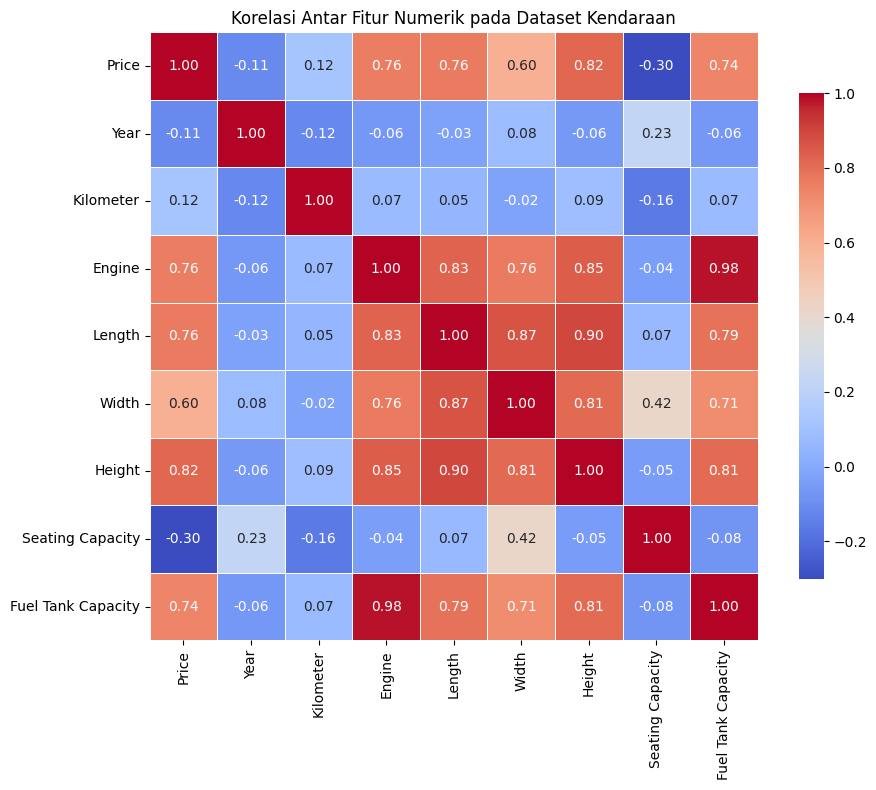

In [ ]:
numerical_features = ['Price', 'Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
corr = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title('Korelasi Antar Fitur Numerik pada Dataset Kendaraan')
plt.tight_layout()
plt.show()


### **Visualisasi Akurasi dan Loss per Epoch**

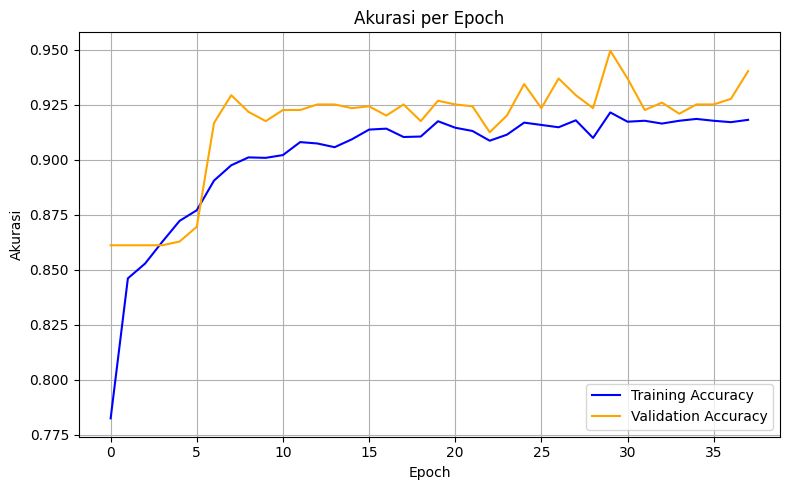

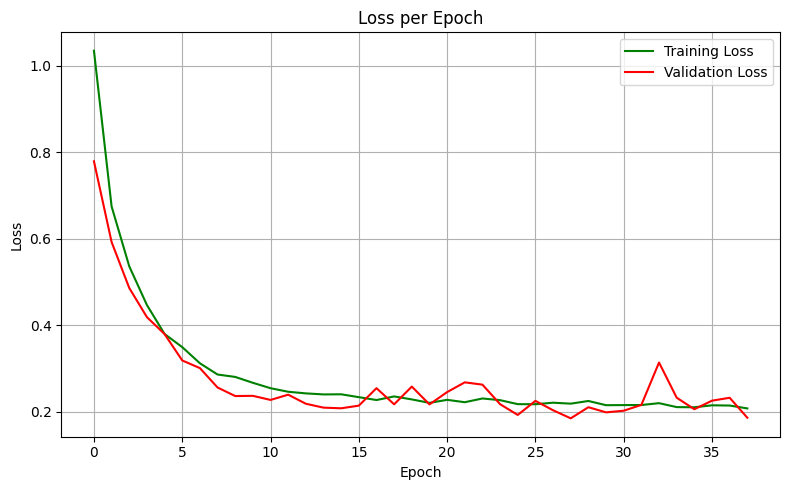

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Evaluasi Ulang + Confusion Matrix Heatmap**

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Akurasi: 0.93

Confusion Matrix:
[[394  80   4]
 [  0 276   0]
 [  0   0 434]]

Classification Report:
              precision    recall  f1-score   support

       Mobil       1.00      0.82      0.90       478
Sepeda Motor       0.78      1.00      0.87       276
        Truk       0.99      1.00      1.00       434

    accuracy                           0.93      1188
   macro avg       0.92      0.94      0.92      1188
weighted avg       0.94      0.93      0.93      1188



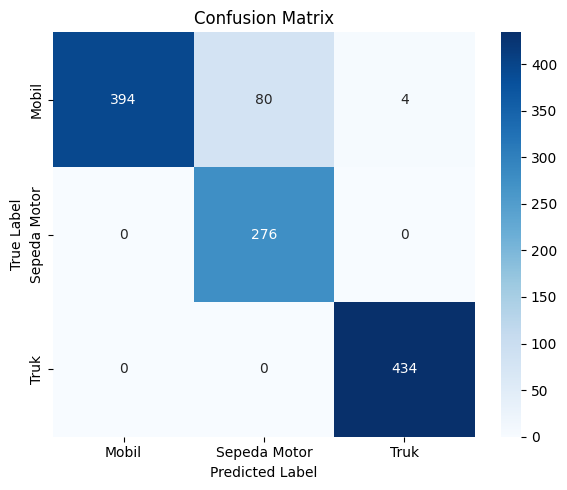

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Akurasi
acc = accuracy_score(Y_test, y_pred)
print(f"Akurasi: {acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Ambil label dari encoder sesuai indeks prediksi
unique_classes = np.unique(np.concatenate((Y_test, y_pred)))
labels = [label_encoder.classes_[i] for i in unique_classes]

# Classification Report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=labels))

# Heatmap Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


### **Prediksi Manual Jenis Kendaraan (Mobil, Truk, Motor)**

In [ ]:
# Data untuk mobil, truk, dan motor
new_data_mobil = {
    'Price': [150000000],  # Harga kendaraan
    'Year': [2020],        # Tahun kendaraan
    'Kilometer': [10000],  # Kilometer kendaraan
    'Engine': [1500],      # Engine size (cc)
    'Length': [4000],      # Panjang kendaraan
    'Width': [1700],       # Lebar kendaraan
    'Height': [1400],      # Tinggi kendaraan
    'Seating Capacity': [5],  # Kapasitas penumpang
    'Fuel Tank Capacity': [50]  # Kapasitas tangki bahan bakar
}

new_data_truk = {
    'Price': [500000000],  # Harga kendaraan
    'Year': [2021],        # Tahun kendaraan
    'Kilometer': [200000], # Kilometer kendaraan
    'Engine': [6000],      # Engine size (cc)
    'Length': [8000],      # Panjang kendaraan
    'Width': [2500],       # Lebar kendaraan
    'Height': [3500],      # Tinggi kendaraan
    'Seating Capacity': [2],  # Kapasitas penumpang
    'Fuel Tank Capacity': [150]  # Kapasitas tangki bahan bakar
}

new_data_motor = {
    'Price': [25000000],   # Harga kendaraan
    'Year': [2022],        # Tahun kendaraan
    'Kilometer': [5000],   # Kilometer kendaraan
    'Engine': [600],       # Engine size (cc)
    'Length': [3500],      # Panjang kendaraan
    'Width': [1000],       # Lebar kendaraan
    'Height': [1000],      # Tinggi kendaraan
    'Seating Capacity': [2],  # Kapasitas penumpang
    'Fuel Tank Capacity': [20]  # Kapasitas tangki bahan bakar
}

# Convert data ke DataFrame
df_new_data_mobil = pd.DataFrame(new_data_mobil)
df_new_data_truk = pd.DataFrame(new_data_truk)
df_new_data_motor = pd.DataFrame(new_data_motor)

# Preprocessing data (ubah 'Engine' menjadi numeric dan hilangkan 'cc')
df_new_data_mobil['Engine'] = df_new_data_mobil['Engine'].astype(str).str.replace(' cc', '', regex=False)
df_new_data_truk['Engine'] = df_new_data_truk['Engine'].astype(str).str.replace(' cc', '', regex=False)
df_new_data_motor['Engine'] = df_new_data_motor['Engine'].astype(str).str.replace(' cc', '', regex=False)

df_new_data_mobil['Engine'] = pd.to_numeric(df_new_data_mobil['Engine'], errors='coerce')
df_new_data_truk['Engine'] = pd.to_numeric(df_new_data_truk['Engine'], errors='coerce')
df_new_data_motor['Engine'] = pd.to_numeric(df_new_data_motor['Engine'], errors='coerce')

# Klasifikasi jenis kendaraan berdasarkan 'Engine'
df_new_data_mobil['vehicle_type'] = df_new_data_mobil['Engine'].apply(classify_vehicle)
df_new_data_truk['vehicle_type'] = df_new_data_truk['Engine'].apply(classify_vehicle)
df_new_data_motor['vehicle_type'] = df_new_data_motor['Engine'].apply(classify_vehicle)

# Scaling data dengan scaler yang sudah dilatih sebelumnya
new_data_mobil_scaled = scaler.transform(df_new_data_mobil[selected_features])
new_data_truk_scaled = scaler.transform(df_new_data_truk[selected_features])
new_data_motor_scaled = scaler.transform(df_new_data_motor[selected_features])

# Prediksi dengan model yang sudah dilatih
new_data_mobil_pred_prob = model.predict(new_data_mobil_scaled)
new_data_truk_pred_prob = model.predict(new_data_truk_scaled)
new_data_motor_pred_prob = model.predict(new_data_motor_scaled)

# Tampilkan probabilitas dan hasil prediksi untuk masing-masing kendaraan
def display_prediction_result(vehicle_type, prob):
    print(f"Sampel Manual {vehicle_type} - Prediksi: {vehicle_type} (Prob: {prob:.2f})")

# Untuk mobil
display_prediction_result("MOBIL", new_data_mobil_pred_prob[0][0])

# Untuk truk
display_prediction_result("TRUK", new_data_truk_pred_prob[0][2])

# Untuk motor
display_prediction_result("MOTOR", new_data_motor_pred_prob[0][1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sampel Manual MOBIL - Prediksi: MOBIL (Prob: 1.00)
Sampel Manual TRUK - Prediksi: TRUK (Prob: 1.00)
Sampel Manual MOTOR - Prediksi: MOTOR (Prob: 0.89)
